# Data Preprocessing

In [1]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score

def rmse(y_true,y_pred):
    return mean_squared_error(y_true,y_pred,squared=False)

In [3]:
# read Bike Sharing data
path = './data/'
df = pd.read_csv(path + "hour.csv.gz", compression="gzip")

orig_predictor_headers = list(df)
outcome_header = "cnt"
used_headers = orig_predictor_headers
used_headers.remove("instant")
used_headers.remove("dteday")
used_headers.remove("casual")
used_headers.remove("registered")
df2 = df[used_headers]

def add_dummy(v, data):
    dummy_cols = v
    dummy = pd.get_dummies(df[dummy_cols], drop_first=True, dtype=float)
    dummy.columns = [dummy_cols+"_{}".format(i) for i in range(dummy.shape[1])]
    data = pd.concat([data, dummy], axis=1)
    data.drop([dummy_cols], axis=1, inplace=True)
    return data

USE_DUMMIES = True
if USE_DUMMIES:
    data = df2
    data = add_dummy('season',data)
    data = add_dummy('weathersit',data)
    
feature_names = list(data)
feature_names.remove('cnt')

y = data['cnt'].values
X = data[feature_names].values

print(X.shape, y.shape)
feature_names

(17379, 16) (17379,)


['yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_0',
 'season_1',
 'season_2',
 'weathersit_0',
 'weathersit_1',
 'weathersit_2']

In [4]:
feature_names_2 = [
'Year', 
'Month',
'Hour',
'Holiday', 
'Weekday', 
'Working day', 
'Temperature',                   
'Feeling temp',                     
'Humidity', 
'Wind speed',
'season_0',
'season_1',
'season_2',
'weathersit_0',
'weathersit_1',
'weathersit_2']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

In [6]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor

clf_1 = RandomForestRegressor()
clf_1.fit(X_train, y_train)
print('rmse train:', rmse(clf_1.predict(X_train), y_train))
print('rmse test:', rmse(clf_1.predict(X_test), y_test))

rmse train: 15.873511214877215
rmse test: 44.10071464527255


In [7]:
clf_2 = GradientBoostingRegressor()
clf_2.fit(X_train, y_train)
print('rmse train:', rmse(clf_2.predict(X_train), y_train))
print('rmse test:', rmse(clf_2.predict(X_test), y_test))

rmse train: 70.53137610064987
rmse test: 70.91322347038376


In [8]:
from sklearn.neural_network import MLPRegressor

clf_3 = MLPRegressor(random_state=1, max_iter=1000)
clf_3.fit(X_train, y_train)
print('rmse train:', rmse(clf_3.predict(X_train), y_train))
print('rmse test:', rmse(clf_3.predict(X_test), y_test))

rmse train: 89.02025677697699
rmse test: 87.26432082800443


/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
from random_forestry import RandomForest

clf_4 = RandomForest()

clf_4.fit(X_train, y_train)

forest_preds_train = clf_4.predict(X_train)
forest_preds = clf_4.predict(X_test)

print("Train:", rmse(y_train, forest_preds_train))
print("Test:", rmse(y_test, forest_preds))

x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


Train: 27.196594784300363
Test: 54.23149729479035


In [10]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from cross_val import k_fold_cross_validation
from sklearn import tree as tr

m1 = tr.DecisionTreeRegressor()
m1.fit(X_train, y_train)
m1_pred = m1.predict(X_train)
m1_pred_test = m1.predict(X_test)
print("Train DT:", rmse(m1_pred, y_train))
print("Test DT:", rmse(m1_pred_test, y_test), "depth", m1.get_depth())

m = LinearRegression()
m.fit(X_train, y_train)
m_pred = m.predict(X_train)
m_pred_test = m.predict(X_test)
print("Train:", rmse(m_pred, y_train))
print("Test:", rmse(m_pred_test, y_test))

Train DT: 0.4211126058431061
Test DT: 63.702211944910815 depth 30
Train: 141.2936422029478
Test: 138.09373583106202


In [11]:
m1.get_n_leaves()

13194

In [12]:
from random_forestry import RandomForest

fr = RandomForest(ntree=1)

fr.fit(X_train, y_train)

forest_preds_train = fr.predict(X_train)
forest_preds = fr.predict(X_test)

print("Train:", rmse(y_train, forest_preds_train))
print("Test:", rmse(y_test, forest_preds))

Train: 64.74855358742042
Test: 95.17500334496427


x does not have column names.  The check that columns are provided in the same order when training and predicting will be skipped


# MLM Method

In [13]:
from generalized_mlm_2 import MixtureLinearModel

2024-11-02 17:41:34.584040: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 17:41:34.589586: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 17:41:34.655450: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 17:41:34.659490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 17:41:36.029505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [14]:
clfs = [clf_1, clf_2, clf_3, clf_4]

sorted_clf = []
for i in clfs:
    sorted_clf.append((i, rmse(i.predict(X_test), y_test)))
sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

In [15]:
avg_variance = np.mean(np.var(X_train, axis=0))

In [16]:
MLM = MixtureLinearModel(sorted_clf, verbose=True)

In [17]:
MLM.compute_kmeans_CELL(X_train, K=100, random_seed=0)

16 (16,)


/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# of CELL:100 / min size:60 / avg size:139.0 / max size:221 / # of singleton CELL:0


In [18]:
MLM.fit_LocalModels(X_train, y_train, 
                    eps=0.01, num_noise_samp=100, 
                    classification=False, alpha=0, max_iter=10000, random_seed=0)

100%|██████████| 100/100 [00:00<00:00, 1324.33it/s]


In [19]:
pred_lmm_train = MLM.predict(X_train, covariance_type='full', covariance_tied=True, uniform_prior=False)
pred_lmm_test = MLM.predict(X_test, covariance_type='full', covariance_tied=True, uniform_prior=False)

100%|██████████| 100/100 [00:00<00:00, 953.61it/s]


In [20]:
print('MLM-CELL: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train, np.array(pred_lmm_train)),
            rmse(y_test, np.array(pred_lmm_test))))

MLM-CELL: Train RMSE:62.730 / Test RMSE:65.607


In [21]:
MLM.fit_MergedLocalModels(150, classification=False, alpha=0, max_iter=1000, random_seed=0)

100%|██████████| 100/100 [00:00<00:00, 166.36it/s]
/storage/work/eak5582/Research/generalized_mlm_2.py:404: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 2671.31it/s]


In [22]:
pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=True, uniform_prior=False)
pred_epic_test = MLM.predict(X_test, merged=True, 
                covariance_type='full', covariance_tied=True, uniform_prior=False)

100%|██████████| 98/98 [00:00<00:00, 437.46it/s]


In [23]:
print('MLM-EPIC: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train, np.array(pred_epic_train)),
            rmse(y_test, np.array(pred_epic_test))))

MLM-EPIC: Train RMSE:62.893 / Test RMSE:65.636


In [24]:
MLM_results_5_run_test = []
MLM_results_5_run_train = []
for run in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    clf_1 = RandomForestRegressor()
    clf_1.fit(X_train, y_train)
    clf_2 = GradientBoostingRegressor()
    clf_2.fit(X_train, y_train)
    clf_3 = MLPRegressor(random_state=None, max_iter=1000)
    clf_3.fit(X_train, y_train)
#     clf_4 = RandomForest()
#     clf_4.fit(X_train, y_train)
    clfs = [clf_1, clf_2, clf_3]
#     clfs = [clf_3]
    sorted_clf = []
    for i in clfs:
        sorted_clf.append((i, rmse(i.predict(X_test), y_test)))
    sorted_clf = sorted(sorted_clf, key=lambda x: x[1])
    avg_variance = np.mean(np.var(X_train, axis=0))
    MLM = MixtureLinearModel(sorted_clf, verbose=True)
    MLM.compute_kmeans_CELL(X_train, K=100, random_seed=None)
    MLM.fit_LocalModels(X_train, y_train, 
                    eps=0.01, num_noise_samp=100, 
                    classification=False, alpha=0, max_iter=10000, random_seed=None)
    pred_lmm_train = MLM.predict(X_train, covariance_type='full', covariance_tied=True, uniform_prior=False)
    pred_lmm_test = MLM.predict(X_test, covariance_type='full', covariance_tied=True, uniform_prior=False)
    MLM.fit_MergedLocalModels(150, classification=False, alpha=0, max_iter=1000, random_seed=None)
    pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=True, uniform_prior=False)
    pred_epic_test = MLM.predict(X_test, merged=True, 
                covariance_type='full', covariance_tied=True, uniform_prior=False)
    
    MLM_results_5_run_train.append(rmse(y_train, np.array(pred_epic_train)))
    MLM_results_5_run_test.append(rmse(y_test, np.array(pred_epic_test)))
# print('std test:', np.std(MLM_results_5_run_test))

16 (16,)


/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# of CELL:100 / min size:94 / avg size:139.0 / max size:207 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 176.12it/s]
/storage/work/eak5582/Research/generalized_mlm_2.py:404: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 1508.86it/s]


16 (16,)


/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# of CELL:100 / min size:86 / avg size:139.0 / max size:212 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 176.67it/s]
/storage/work/eak5582/Research/generalized_mlm_2.py:404: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 1452.08it/s]
/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


16 (16,)
# of CELL:100 / min size:74 / avg size:139.0 / max size:206 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 177.76it/s]
/storage/work/eak5582/Research/generalized_mlm_2.py:404: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 1455.49it/s]
/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


16 (16,)
# of CELL:100 / min size:93 / avg size:139.0 / max size:212 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 177.75it/s]
/storage/work/eak5582/Research/generalized_mlm_2.py:404: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 1314.31it/s]
/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/storage/home/eak5582/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


16 (16,)
# of CELL:100 / min size:82 / avg size:139.0 / max size:197 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 176.85it/s]
/storage/work/eak5582/Research/generalized_mlm_2.py:404: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 1470.79it/s]


In [25]:
#Results
print("Test:", MLM_results_5_run_test, "\nTrain:", MLM_results_5_run_train)
print('std test:', np.std(MLM_results_5_run_test))
print('Mean test:', np.mean(MLM_results_5_run_test))

Test: [70.11807173321922, 67.88835084156723, 67.78131622493898, 66.4059050798359, 65.39823978959961] 
Train: [64.21611855733826, 61.56794895574754, 63.84770279451537, 63.111441316080025, 61.674865668609584]
std test: 1.5935498705381559
Mean test: 67.5183767338322


# SynthTree

### Selecting the best K

In [15]:
from sklearn.metrics import f1_score
import numpy as np

#Mutual prediction disparity functions

def regression_distance(model_s, model_t, data_s, data_t, m):
    n_s = len(data_s)
    n_t = len(data_t)

    sum_squared_diff = np.sum((model_s.predict(data_s) - model_t.predict(data_s))**2)
    sum_squared_diff += np.sum((model_s.predict(data_t) - model_t.predict(data_t))**2)

    distance = sum_squared_diff / (n_s + n_t + 2*m)
    return distance

def classification_distance(model_s, model_t, data_s, data_t, m):
    predictions_s = model_s.predict(data_s)
    predictions_t = model_t.predict(data_s)
    
    predictions_s = np.round(np.concatenate((predictions_s, model_s.predict(data_t))))
    predictions_t = np.round(np.concatenate((predictions_t, model_t.predict(data_t))))

    tp = np.sum((predictions_s == 1) & (predictions_t == 1))
    fp = np.sum((predictions_s == 1) & (predictions_t == 0))
    fn = np.sum((predictions_s == 0) & (predictions_t == 1))

    if tp == 0:
        distance = np.inf
    else:
        distance = (fp + fn) / (2 * tp)

    return distance


def dist_matrix(num_clusters, classification = False):
    distance_matrix = np.zeros((num_clusters, num_clusters))
    if classification == False:
        for s in range(num_clusters):
            for t in range(num_clusters):
                if s == t:
                    distance_matrix[s, t] = 0.0
                else:
                    distance_matrix[s, t] = regression_distance(models_all[num_clusters][s], models_all[num_clusters][t], augmented_data[num_clusters][s], augmented_data[num_clusters][t], m)

    if classification:
        for s in range(num_clusters):
            for t in range(num_clusters):
                if s == t:
                    distance_matrix[s, t] = 0.0
                else:
                    distance_matrix[s, t] = classification_distance(models_all[num_clusters][s], models_all[num_clusters][t], augmented_data[num_clusters][s], augmented_data[num_clusters][t], m)
    return distance_matrix

In [30]:
m = 100 # Number of new points used for data augmentation (by co-supervision)
min_var = np.mean(np.var(X_train, axis=0))

def predict_mixture_of_models(X, local_models, kmeans):
    cluster_assignments = kmeans.predict(X)
    
    predictions = np.zeros_like(X[:, 0]) 

    for cluster, model in enumerate(local_models):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X[cluster_indices]
        predictions[cluster_indices] += model.predict(X_cluster)

    return predictions

def evaluate_overall_model(X, y, k, clf_models, classification=False):
    kmeans = KMeans(n_clusters=k, n_init=100)
    cluster_assignments = kmeans.fit_predict(X)
    
    roc_score = float('inf')

    local_models = []
    for cluster in range(k):
        cluster_indices = np.where(cluster_assignments == cluster)

        X_cluster = X[cluster_indices]
        y_cluster = y[cluster_indices]
        
        if len(np.unique(y_cluster)) < 2:
            clf = sorted_clf[-1][0]
#             print("cluster:", cluster)
        else:
            for i in clf_models:
#                 print("model in cluster:", i, "accuracy", roc_auc_score(y_cluster, i.predict(X_cluster)))
                if rmse(y_cluster, i.predict(X_cluster)) <= roc_score:
                    roc_score = rmse(y_cluster, i.predict(X_cluster))
                    clf = i
#                 print("best model:", clf)

        def chol_sample(mean, cov, size=1):
            cholesky_cov = np.linalg.cholesky(cov)
            random_samp = np.array([mean + cholesky_cov @ np.random.standard_normal(mean.size) for i in range(size)])
            return random_samp
        
#         cov = np.diag(np.zeros(X_cluster.shape[1]) + 0.001)
        
        sample_mean = np.mean(X_cluster, axis=0)
            
#         perturbed_samples = chol_sample(sample_mean, cov, m)

        variances = np.var(X_cluster, axis=0)
  
        perturbed_samples = np.random.normal(loc=sample_mean, scale=np.sqrt(variances), size=(m, X_cluster.shape[1]))
        
        perturbed_predictions = clf.predict(perturbed_samples)
        
        X_cluster = np.concatenate((X_cluster, perturbed_samples))
        y_cluster = np.concatenate((y_cluster, perturbed_predictions))
        augmented_data[k][cluster] = X_cluster
        augmented_y[k][cluster] = y_cluster
        clf_model[k][cluster] = clf

        if classification == True:
            if len(np.unique(y_cluster)) == 1:
                model = LogisticRegression(solver='saga')
                model.classes_ = np.unique(y_cluster)
                model.coef_ = np.zeros((1, X.shape[1]))
                model.intercept_ = 0.0
            else:
                model = LogisticRegression(solver='saga')
                model.fit(X_cluster, y_cluster)
        else:
            model = LinearRegression()
            model.fit(X_cluster, y_cluster)
        local_models.append(model)
        models_all[k][cluster] = model

    predictions = predict_mixture_of_models(X, local_models, kmeans)
    overall_score = rmse(y, predictions)
    
    return overall_score, augmented_data, augmented_y, models_all

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Set the maximum possible value of k
max_k = 50

# Iterate over different values of k and record the performance
best_k = None
best_score = float('inf')
augmented_data = {}
augmented_y = {}
models_all = {}
clf_model = {}

clfs = [clf_1, clf_2, clf_3, clf_4]
# clfs = [clf_1]

sorted_clf = []
for i in clfs:
    sorted_clf.append((i, rmse(i.predict(X_train), y_train)))
sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

for k in range(10, max_k + 1, 10):
    print("k:", k)
    augmented_data[k] = {}
    augmented_y[k] = {}
    models_all[k] = {}
    clf_model[k] ={}
    
    overall_score = evaluate_overall_model(X_train, y_train, k, clfs, classification=False)

    # Update best_k if a higher overall score is achieved
    if overall_score[0] < best_score:
        best_score = overall_score[0]
        best_k = k

# Final model using the best k
kmeans = KMeans(n_clusters=best_k, n_init=100)
cluster_assignments = kmeans.fit_predict(X_train)

local_models = []
for cluster in range(best_k):
    cluster_indices = np.where(cluster_assignments == cluster)
    X_cluster = X_train[cluster_indices]
    y_cluster = y_train[cluster_indices]

    model = LinearRegression()
    model.fit(X_cluster, y_cluster)
    local_models.append(model)

predictions = predict_mixture_of_models(X_train, local_models, kmeans)
print(f"Best k: {best_k}, Best RMSE score: {best_score}")
print("RMSE:", rmse(y_train, predictions))

k: 10
k: 20
k: 30
k: 40
k: 50
Best k: 50, Best RMSE score: 77.98333592556317
RMSE: 74.03764153493239


### Growing the Tree

In [31]:
best_k = 50
kmeans = KMeans(n_clusters=best_k, n_init=100)
cluster_assignments = kmeans.fit_predict(X_train)

In [32]:
# Function to predict using the mixture of linear models
def predict_mixture_of_models(X, local_models, kmeans):
    cluster_assignments = kmeans.predict(X)
    
    predictions = np.zeros_like(X[:, 0])  # Initialize predictions

    for cluster, model in enumerate(local_models):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X[cluster_indices]
        predictions[cluster_indices] += model.predict(X_cluster)

    return predictions

# Function to evaluate overall model performance for a given k
def evaluate_overall_model(X, y, k, clf_models, classification=False):
    rmse_score = float('inf')

    local_models = []
    for cluster in range(k):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X_train[cluster_indices]
        y_cluster = y_train[cluster_indices]
        
        if len(np.unique(y_cluster)) < 2:
            clf = sorted_clf[0][0]
#             print("cluster:", cluster)
        else:
            for i in clf_models:
                if rmse(y_cluster, i.predict(X_cluster)) <= rmse_score:
                    rmse_score = rmse(y_cluster, i.predict(X_cluster))
                    clf = i
                    
        sample_mean = np.mean(X_cluster, axis=0)
        
        variances = np.var(X_cluster, axis=0)
  
        perturbed_samples = np.random.normal(loc=sample_mean, scale=np.sqrt(variances), size=(m, X_cluster.shape[1]))
        
        perturbed_predictions = clf.predict(perturbed_samples)
        
        X_cluster = np.concatenate((X_cluster, perturbed_samples))
        y_cluster = np.concatenate((y_cluster, perturbed_predictions))
        augmented_data[k][cluster] = X_cluster
        augmented_y[k][cluster] = y_cluster
        clf_model[k][cluster] = clf

        if classification == True:
            if len(np.unique(y_cluster)) == 1:
                model = LogisticRegression(solver='saga')
                model.classes_ = np.unique(y_cluster)
                model.coef_ = np.zeros((1, X_train.shape[1]))
                model.intercept_ = 0.0
            else:
                model = LogisticRegression(solver='saga')
                model.fit(X_cluster, y_cluster)
        else:
            model = LinearRegression()
            model.fit(X_cluster, y_cluster)
        local_models.append(model)
        models_all[k][cluster] = model

    predictions = predict_mixture_of_models(X_train, local_models, kmeans)
    overall_score = rmse(y_train, predictions)
    
    return overall_score, augmented_data, augmented_y, models_all

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)


ROC_test = []
ROC_train = []
ROC_beom_train = []
ROC_beom_test = []
Best_depth = []

results = []
m = 100

clfs = [clf_1, clf_2, clf_3, clf_4]
# clfs = [clf_1]

for test in range(1):
    # Set the maximum possible value of k
    max_k = 50

    # Iterate over different values of k and record the performance
    best_score = float('-inf')  # Initialize with a very low value
    augmented_data = {}
    augmented_y = {}
    models_all = {}
    clf_model = {}

    sorted_clf = []
    for i in clfs:
        sorted_clf.append((i, rmse(i.predict(X_train), y_train)))
    sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

    for k in range(50, max_k + 1):
        print("k:", k)
        augmented_data[k] = {}
        augmented_y[k] = {}
        models_all[k] = {}
        clf_model[k] ={}

        overall_score = evaluate_overall_model(X_train, y_train, k, clfs, classification=False)

        # Update best_k if a higher overall score is achieved
        if overall_score[0] <= best_score:
            best_score = overall_score[0]
            best_k = k

    local_models = []
    for cluster in range(best_k):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X_train[cluster_indices]
        y_cluster = y_train[cluster_indices]

        model = LinearRegression()
        model.fit(X_cluster, y_cluster)
        local_models.append(model)

    predictions = predict_mixture_of_models(X_train, local_models, kmeans)

    import statistics

    dist = pd.DataFrame(dist_matrix(best_k, classification=False))

    CELL_centers = []
    CELL_variances = []
    for i in augmented_data[best_k]:
        CELL_variances.append(np.sqrt(np.var(augmented_data[best_k][i], axis=0)))
        CELL_centers.append(np.mean(augmented_data[best_k][i], axis=0))
    cells_df = pd.DataFrame(CELL_centers)

    y_local = []
    for i in range(len(CELL_centers)):
        y_local.append(statistics.mode(augmented_y[best_k][i]))


    import DECISION_TREE_CLASSIFIER as dtc

    for k in range(1, 2):
        rmse_curr = float('inf')
        rmse_curr_train = float('inf')
        best_depth = float('inf')

        tree = dtc.DistanceDecisionTree(max_depth=5, classification=False)

        tree.fit(np.array(cells_df), np.array(dist))

        data_transformed = [augmented_data[best_k][key] for key in range(len(augmented_data[best_k]))]
        data_transformed_y = [augmented_y[best_k][key] for key in range(len(augmented_y[best_k]))]
            
        X_transformed = np.array([item for sublist in [arr.tolist() for arr in data_transformed] for item in sublist])
        y_transformed = np.array([item for sublist in [arr.tolist() for arr in data_transformed_y] for item in sublist])
  
        print("Max Depth", tree.final_depth)

        cv_scores = {}
        test_score = {}
        train_score = {}
        
        for i in range(1, tree.final_depth + 1):
            
            fold_scores = []
            fold_test = []
            fold_train = []
            
            for train_idx, val_idx in kf.split(X_transformed):

                X_train_fold, X_val = X_transformed[train_idx], X_transformed[val_idx]
                y_train_fold, y_val = y_transformed[train_idx], y_transformed[val_idx]
            
                tree = dtc.DistanceDecisionTree(max_depth=i, classification=False)

                tree.fit(np.array(cells_df), np.array(dist))

                tree.fit_leaf_logistic_models(X_train_fold, y_train_fold)

                Y_pred_train = tree.predict(X_train_fold, y_train_fold)
                Y_pred_train = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred_train]
                Y_pred = tree.predict(X_val, y_val)
                Y_pred = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred]
                Y_pred_test = tree.predict(X_test, y_test)
                Y_pred_test = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred_test]

                fold_accuracy = rmse(y_val, Y_pred)
                
                fold_scores.append(fold_accuracy)
                fold_train.append(rmse(y_train, tree.predict(X_train, y_train)))
                fold_test.append(rmse(y_test, Y_pred_test))

            print(f"Current Depth: {i}")
            cv_scores[i] = np.mean(fold_scores)
            test_score[i] = np.mean(fold_test)
            train_score[i] = np.mean(fold_train)
            
            new_dict = {key: cv_scores[key] for key in list(cv_scores.keys())[:-1]}
            if len(cv_scores) > 1  and cv_scores[i] < min(new_dict, key=lambda k: new_dict[k]):
                best_tree = tree
                
    best_depth = min(cv_scores, key=lambda k: cv_scores[k])
    print("Best Depth:", best_depth, "Train:", train_score[best_depth], "Test:", 
          test_score[best_depth], "Val:", cv_scores[best_depth])
#     print("Models", clfs)    

k: 50
Max Depth 5
Current Depth: 1
Current Depth: 2
Current Depth: 3
Current Depth: 4
Current Depth: 5
Best Depth: 5 Train: 75.99966863081676 Test: 75.7489154563689 Val: 79.47348156573163


In [37]:
tree.print_tree()

Feature 2 <= 12.479362436152524
Left:
  Feature 2 <= 7.4756387790193655
  Left:
    Feature 2 <= 4.314863688018218
    Left:
      Feature 6 <= 0.507260638226311
      Left:
        Feature 0 <= 0.5011943343088681
        Left:
          Leaf: Accuracy Test= 15.1634
          Model: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14bcb01b5c90>
        Right:
          Leaf: Accuracy Test= 20.0375
          Model: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14bcb01b5d20>
      Right:
        Feature 3 <= 0.007500254460052318
        Left:
          Leaf: Accuracy Test= 21.2100
          Model: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14bcb01b5e10>
        Right:
          Leaf: Accuracy Test= 23.0606
          Model: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x14bcb01b5f00>
    Right:
      Feature 2 <= 5.5637546048823125
      Left:
        Feature 2 <= 4.6589945343201

In [38]:
def collect_models_from_tree(node, models_list, leaves_sizes):
    if 'leaf' in node:
        models_list.append(node['model'])
        leaves_sizes.append(len(node['data_indices']))
    else:
        if 'left' in node:
            collect_models_from_tree(node['left'], models_list, leaves_sizes)
        if 'right' in node:
            collect_models_from_tree(node['right'], models_list, leaves_sizes)

In [39]:
MODELS = []
leaves_sizes = []
collect_models_from_tree(tree.tree, MODELS, leaves_sizes)

In [40]:
MODELS = [value for value in MODELS if value is not None]

In [41]:
final_df = pd.DataFrame()
final_df['size'] = leaves_sizes
final_df['model'] = MODELS

In [44]:
final_df = final_df.sort_values('size', ascending=False)

In [46]:
models_top = np.array(final_df.iloc[:5, 1])

In [47]:
def plot_ci(MODELS, feature_id, epic_id=None, feature_names=feature_names_2, intercept=True, sort=True, log_trans=True, ax=None, yticklabels=True, title=True):
    if ax == None:
        f, ax = plt.subplots(1,1,figsize=(3,7),dpi=600)
    
    param = np.array([MODELS[i].params for i in range(len(MODELS))])
    cilb = np.transpose([MODELS[i].conf_int() for i in range(len(MODELS))])[0]
    ciub = np.transpose([MODELS[i].conf_int() for i in range(len(MODELS))])[1]

    if epic_id == None:
        epic_id = range(param.shape[0])

    def log(x): return np.sign(x)*np.log(np.abs(x)+1)
    if log_trans:
        param = log(param)
        cilb = log(cilb)
        ciub = log(ciub)

    param = param[epic_id,:]
    cilb = cilb[:,epic_id]
    ciub = ciub[:,epic_id]

    data_dict = {}
    data_dict['category'] = ['ELC'+str(i+1) for i in epic_id]
    data_dict['coef'] = param[:,feature_id]
    data_dict['lower'] = cilb[feature_id,:]
    data_dict['upper'] = ciub[feature_id,:]
    dataset = pd.DataFrame(data_dict)
    
    defcol = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for coef,lower,upper,y in zip(dataset['coef'],dataset['lower'],dataset['upper'],range(len(dataset))):
        ax.plot((lower,upper),(y,y),'-',color='#74a9cf', linewidth=3, alpha=0.9)
        ax.scatter(coef,y,color='black')
    ax.set_yticks(range(len(dataset)))
    ax.set_yticklabels(list(dataset['category']))
    ax.axvline(x=0,color='black',linewidth=1)
    if title:
        ax.set_title(feature_names[feature_id])

In [48]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_mosaic(MODELS, epic_id=None, feature_names=feature_names_2, intercept=True, sort=True, log_trans=True, ax=None):
    if ax == None:
        f, ax = plt.subplots(figsize=(7,3),dpi=300)
    
    cmap=plt.get_cmap('RdBu_r')
    param = np.array([MODELS[i].params for i in range(len(MODELS))])

    if epic_id == None:
        epic_id = range(param.shape[0])

    if log_trans:
        param = np.sign(param)*np.log(np.abs(param)+1)

    param = param[epic_id,:]

    if intercept:
        feature_names = np.concatenate([['intercept'],feature_names])

    vmax = np.max(np.abs(param))
    im = ax.imshow(param, cmap=cmap, vmin=-vmax, vmax=vmax)

    plt.xticks(ticks=range(0,len(feature_names)))
    ax.set_xticklabels(feature_names, rotation = 90)
    plt.yticks(ticks=range(0,len(epic_id)), labels = [i+1 for i in epic_id])
    plt.ylabel('ELC')
    plt.xlabel('Variable')


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

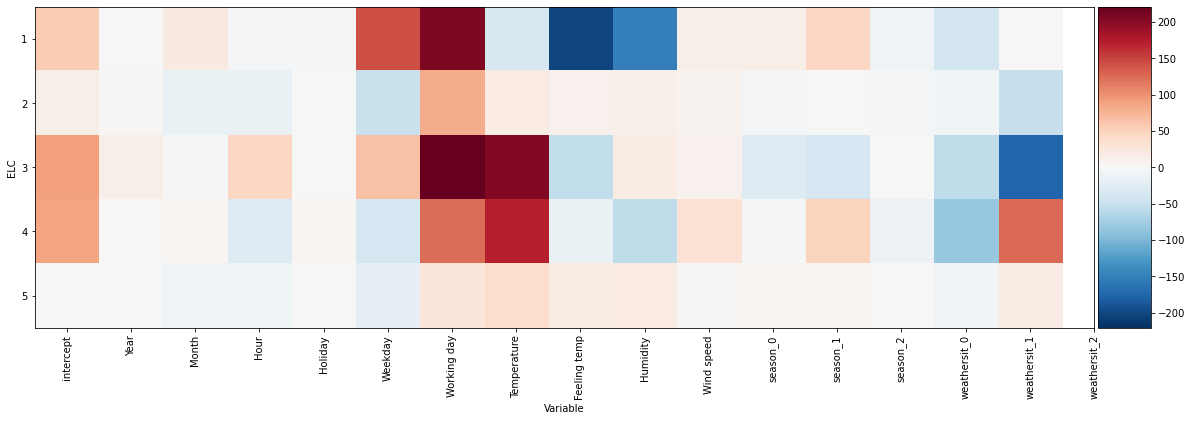

In [49]:
from matplotlib import pyplot as plt
import importlib

fig, ax = plt.subplots(figsize=(20, 10))
plot_mosaic(models_top, epic_id=range(5), log_trans=False, ax=ax)
# plt.savefig('Bike_Sharing_heatmap_2.pdf')

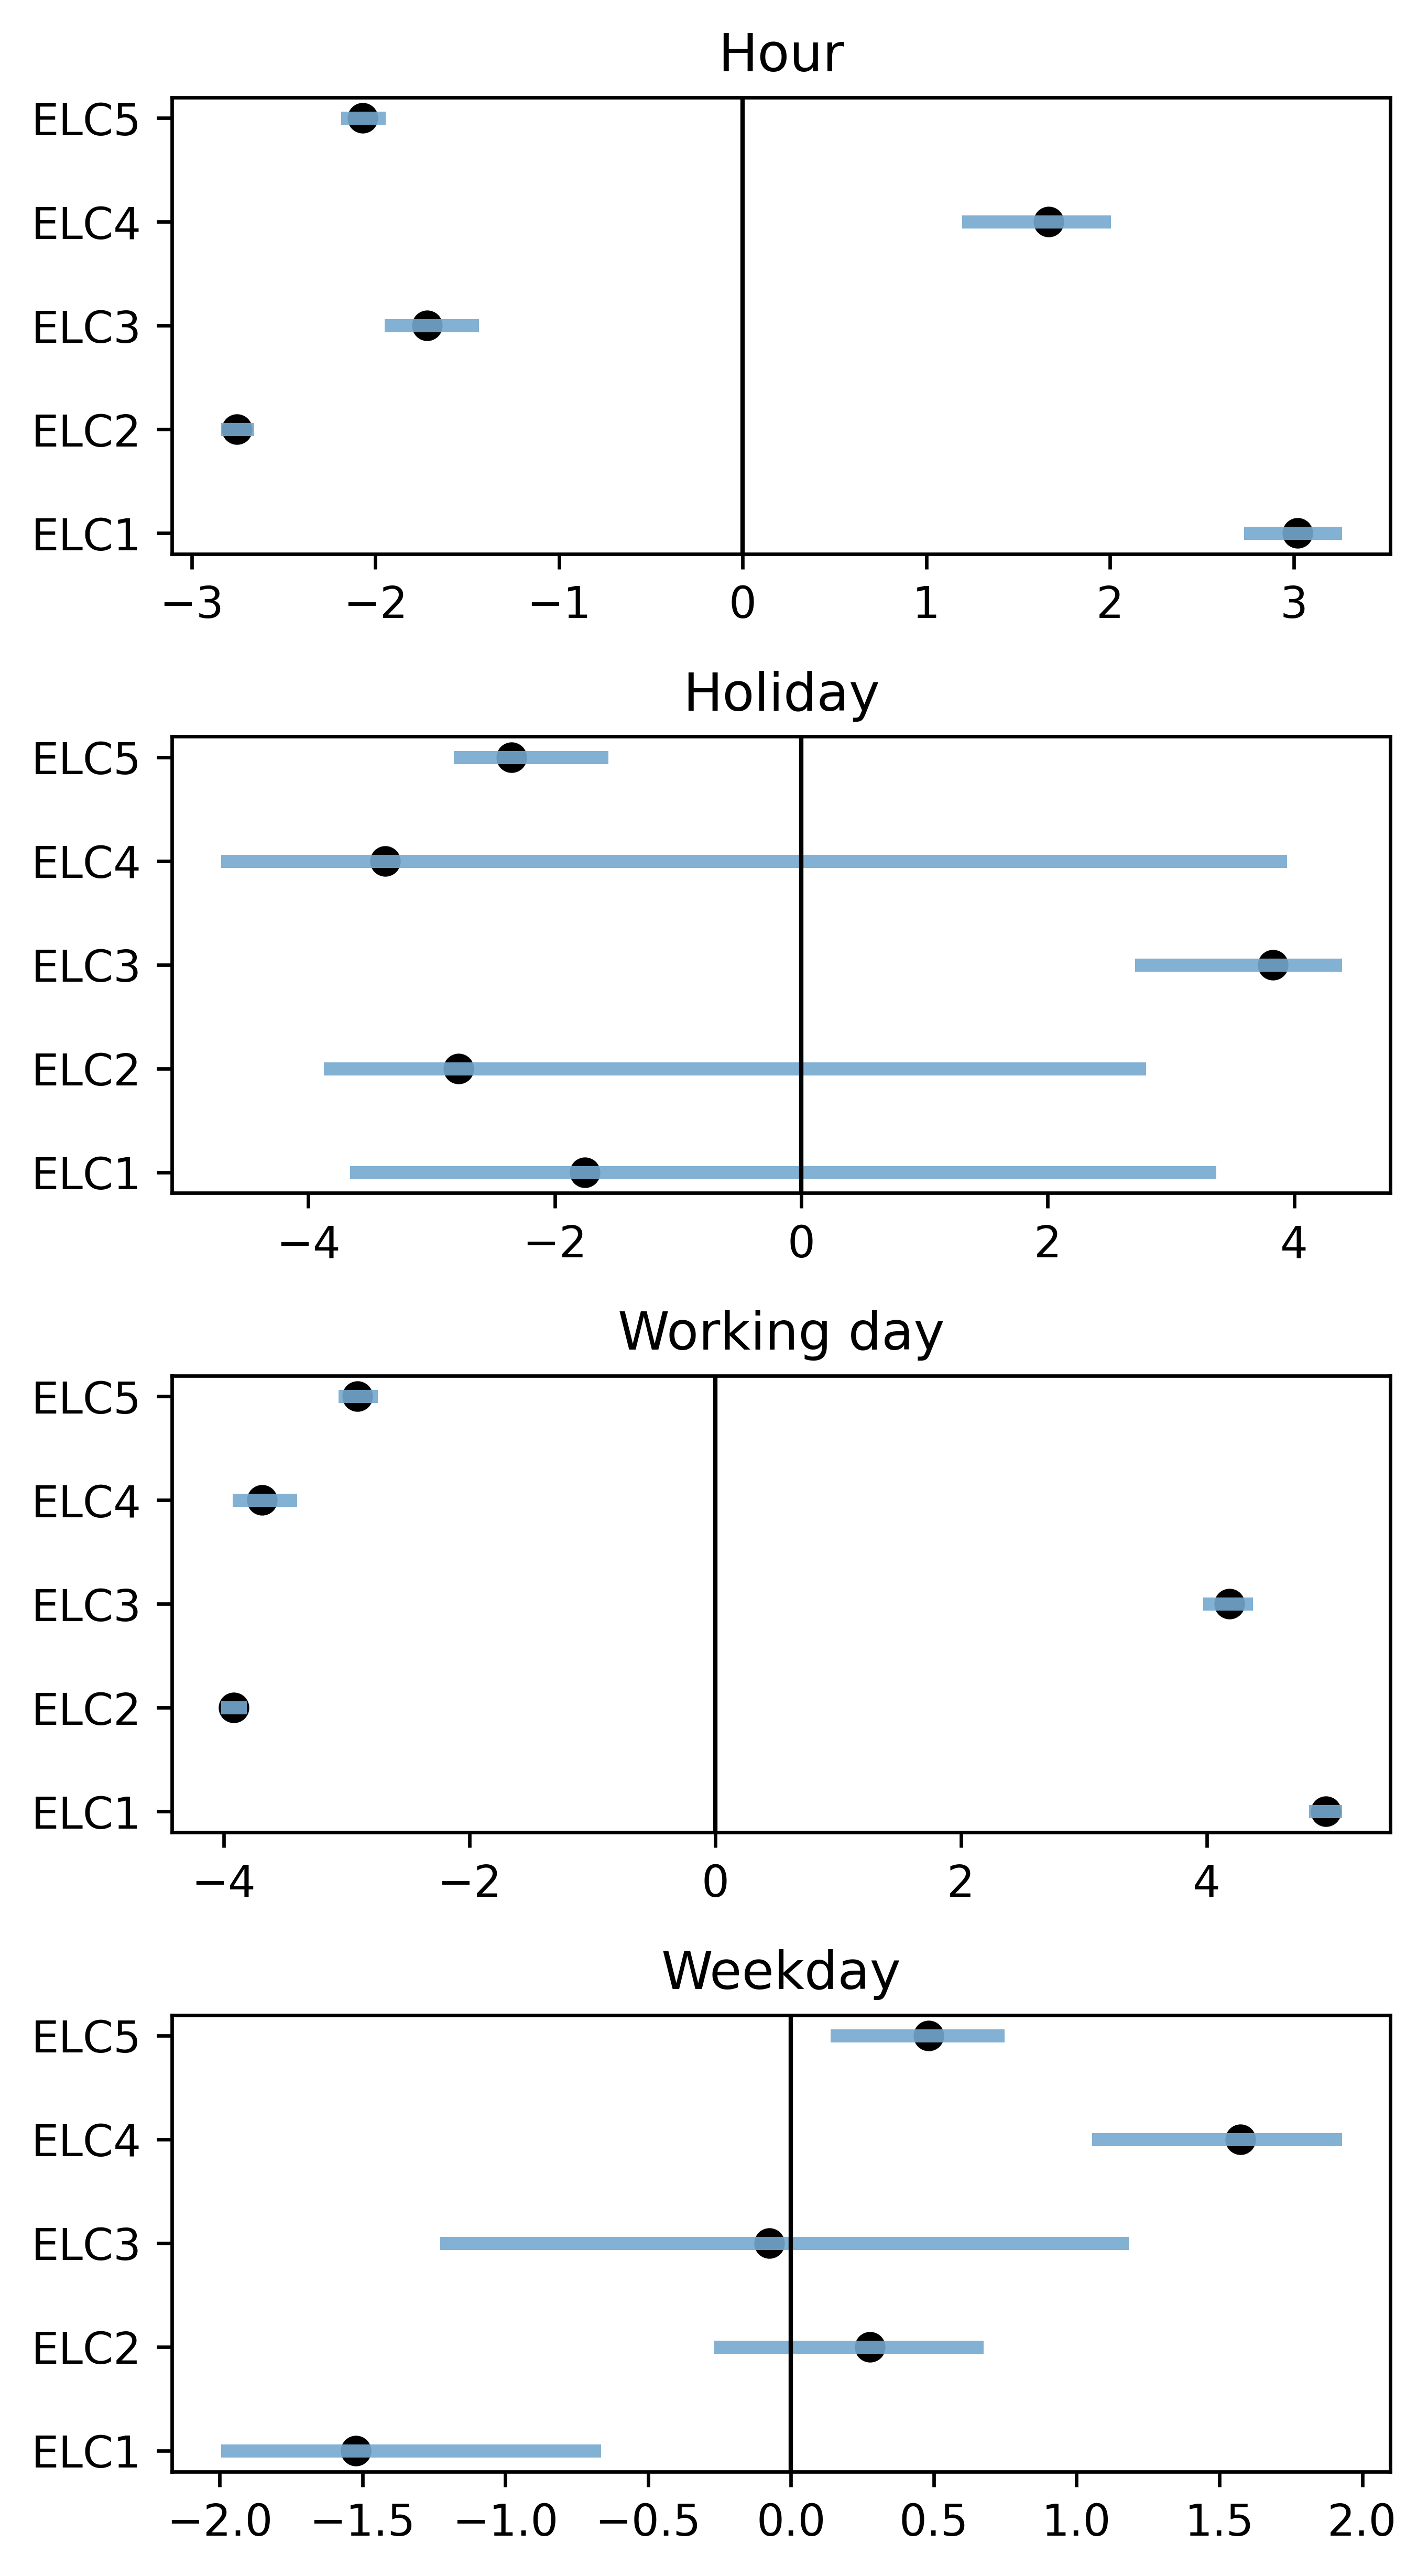

In [51]:
f, axs = plt.subplots(4,1,figsize=(5,10),dpi=600)
plt.subplots_adjust(hspace=0.4)
for i in range(4):
    j = (2,3,5,4)[i]
    ax = plt.subplot(4,1,i+1)
    plot_ci(models_top,j,epic_id=range(5),ax=ax,title=True)
    
# plt.subplots_adjust(hspace=0.5)